In [ ]:
!pip install sentence-transformers

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
categories = [
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'soc.religion.christian',
]

dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
data = {'text': dataset.data, 'target': dataset.target}
df = pd.DataFrame(data)

# 删除空文本行
df = df[df['text'].str.strip() != '']

df = df.reset_index(drop=True)

# 指定要删除的行的索引
removes = [136, 219, 541, 654, 732, 739, 792, 842, 1065]

# 删除指定的行
df = df.drop(removes, errors='ignore')

df = df.reset_index(drop=True)

removes = [109, 298, 331, 1328]

# 删除指定的行
df = df.drop(removes, errors='ignore')

# 查看数据集信息以确认更改
df = df.reset_index(drop=True)
print(df.info())

数据预处理分析（不要运行下面的单元）

In [ ]:
categories = [
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'soc.religion.christian',
]

dataset_r = fetch_20newsgroups(subset='train', categories=categories,shuffle=True, remove=('headers', 'footers', 'quotes'))
data_r = {'text': dataset_r.data, 'target': dataset_r.target}
df_r = pd.DataFrame(data_r)

In [ ]:
print('raw text1:\n',df['text'][0])
print()
print('raw text2:\n',df['text'][1500])
print()
print('raw text3:\n',df['text'][2001])
print()

In [ ]:
print('preprocessed text1:\n',df_r['text'][0])
print()
print('preprocessed text2:\n',df_r['text'][1500])
print()
print('preprocessed text3:\n',df_r['text'][2001])
print()

In [ ]:
categories = dataset.target_names
df['category_name'] = df['target'].apply(lambda x: categories[x])
print(df.head())
print(df['target'].value_counts())

In [ ]:
import matplotlib.pyplot as plt

# 数据准备
categories = ['windows', 'autos', 'space', 'baseball', 'politics']
counts = [591, 594, 597, 593, 465]

# 绘制条形图
plt.figure(figsize=(6, 4))
plt.bar(categories, counts, width=0.5)  # width参数控制柱子的宽度
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Different Categories')
plt.xticks(rotation=45)
plt.show()

TF-IDF Vectorization

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95, stop_words='english')
X = vectorizer.fit_transform(df['text']).toarray()

In [ ]:
print(df['text'][1])
print(sorted(X[1], reverse=True))

In [ ]:
import itertools
first_10_items = dict(itertools.islice(vectorizer.vocabulary_.items(), 10))
print(first_10_items)

{'good': 2353, 'isn': 2718, 'turned': 4971, 'worth': 5287, 'run': 4259, 'atm': 816, 'especially': 1954, 'better': 952, 'printer': 3850, 'tt': 4965}


In [ ]:
from sklearn.decomposition import TruncatedSVD
X_tfidf = vectorizer.fit_transform(df['text'])
svd = TruncatedSVD(n_components=384)  # n_components是新特征空间的维度
X_reduced = svd.fit_transform(X_tfidf)

In [ ]:
X_reduced.shape

(1731, 384)

Glove

In [ ]:
embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 256
embedding_dim = 100

# define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))

    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]

    return embedding_sentence.flatten()

df['encode_glove'] = df['text'].apply(lambda sentence: sentence_embedding(sentence))
X_glove = np.vstack(df['encode_glove'])

.vector_cache/glove.6B.zip: 862MB [03:18, 4.34MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 18084.22it/s]


In [ ]:
for i in range(len(X_glove)):
  if sum(X_glove[i]) == 0:
    print(i,',')

Doc2Vec

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# 假设df['text']是包含文本数据的DataFrame列
documents = [TaggedDocument(words=word_tokenize(text.lower()), tags=[i]) for i, text in enumerate(df['text'])]

# 训练Doc2Vec模型
model = Doc2Vec(documents, vector_size=384, window=2, min_count=1, workers=4)

# 定义函数来获取文本的Doc2Vec嵌入
def document_embedding(text):
    return model.infer_vector(gensim.utils.simple_preprocess(text))

# 应用函数获取嵌入
df['encode_doc2vec'] = df['text'].apply(document_embedding)

# 将嵌入转换为NumPy数组
X_doc2vec = np.vstack(df['encode_doc2vec'])

print(df['encode_doc2vec'][0].shape, X_doc2vec.shape)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(384,) (1731, 384)


Sentence Transformer

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
df['encode_transforemers'] = df['text'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())
X_transformers = np.vstack(df['encode_transforemers'])

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
X_transformers.shape

(1731, 384)

BERT

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to('cuda')

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)]).cuda()

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]

    return cls_embedding.flatten().cpu()

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to('cuda')

def get_sentence_embedding(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)]).cuda()

    # Pass input through BERT model
    with torch.no_grad():
        outputs = model(input_ids)

    # Get all token embeddings
    all_token_embeddings = outputs[0]

    # Calculate the average embedding of all tokens (excluding padding tokens)
    mask = input_ids != tokenizer.pad_token_id
    masked_embeddings = all_token_embeddings * mask.unsqueeze(-1)
    num_tokens = torch.sum(mask, dim=1)  # count how many tokens are in the sentence
    averaged_embedding = torch.sum(masked_embeddings, dim=1) / num_tokens.unsqueeze(-1)

    # Flatten the tensor and convert to CPU
    return averaged_embedding.flatten().cpu()



In [ ]:
df['cls_bert'] = df['text'].apply(lambda sentence: get_sentence_embedding(sentence))

X_cls_bert = np.vstack(df['cls_bert'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


训练和测试

In [ ]:
def kmeans_eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)

    # 计算 NMI, and FMI
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)
    # 计算轮廓系数
    silhouette_avg = silhouette_score(embedding, y_pred)
    # 计算Davies-Bouldin指数
    db_index = davies_bouldin_score(embedding, y_pred)

    # Print Metrics scores
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))
    print("Silhouette Score: {:.3f}".format(silhouette_avg))
    print("Davies-Bouldin Index: {:.3f}".format(db_index))

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score


def hierarchical_eval_cluster(embedding):
    y_pred = hierarchical.fit_predict(embedding)
    #y_pred = spectral.fit_predict(embedding)

    # 计算 NMI, and FMI
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)
    # 计算轮廓系数
    silhouette_avg = silhouette_score(embedding, y_pred)
    # 计算Davies-Bouldin指数
    db_index = davies_bouldin_score(embedding, y_pred)

    # Print Metrics scores
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))
    print("Silhouette Score: {:.3f}".format(silhouette_avg))
    print("Davies-Bouldin Index: {:.3f}".format(db_index))

In [ ]:
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    df[f'x0_{method}'] = x0
    df[f'x1_{method}'] = x1

In [ ]:
def plot_pca_kmeans(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"KMeans 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_pca_kmeans_true(x0_name, x1_name, method):
    plt.figure(figsize=(12, 7))

    plt.title(f"20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    # 使用真实标签作为颜色
    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue="target", palette="viridis")
    plt.show()

In [ ]:
def plot_pca_hierarchical(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"Hierarchical 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Normalized Mutual Information (NMI): 0.739
Fowlkes-Mallows Index (FMI): 0.853
Silhouette Score: 0.010
Davies-Bouldin Index: 9.333
predict:


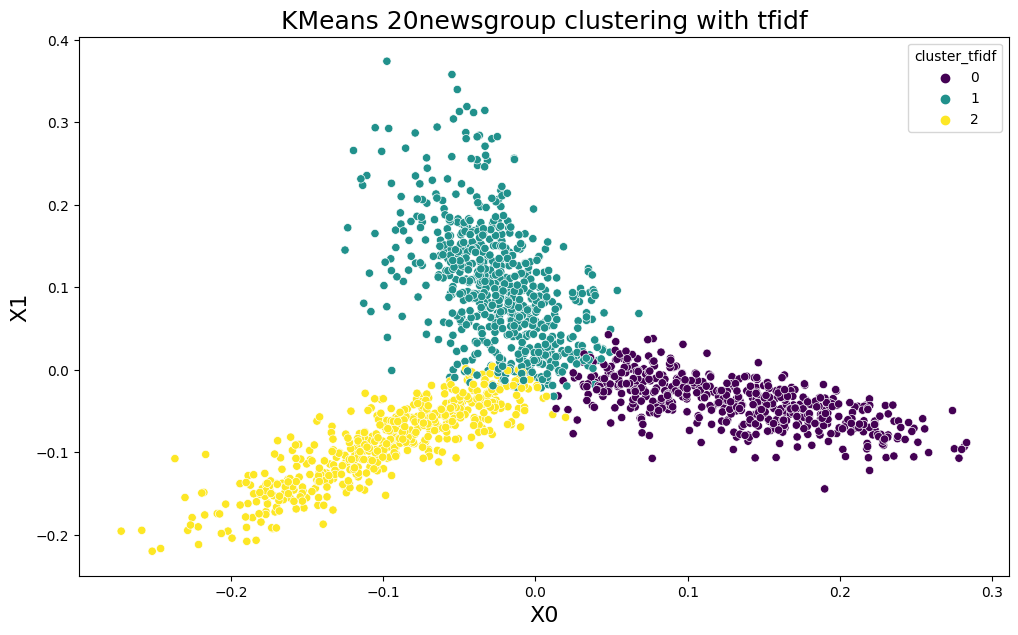

true


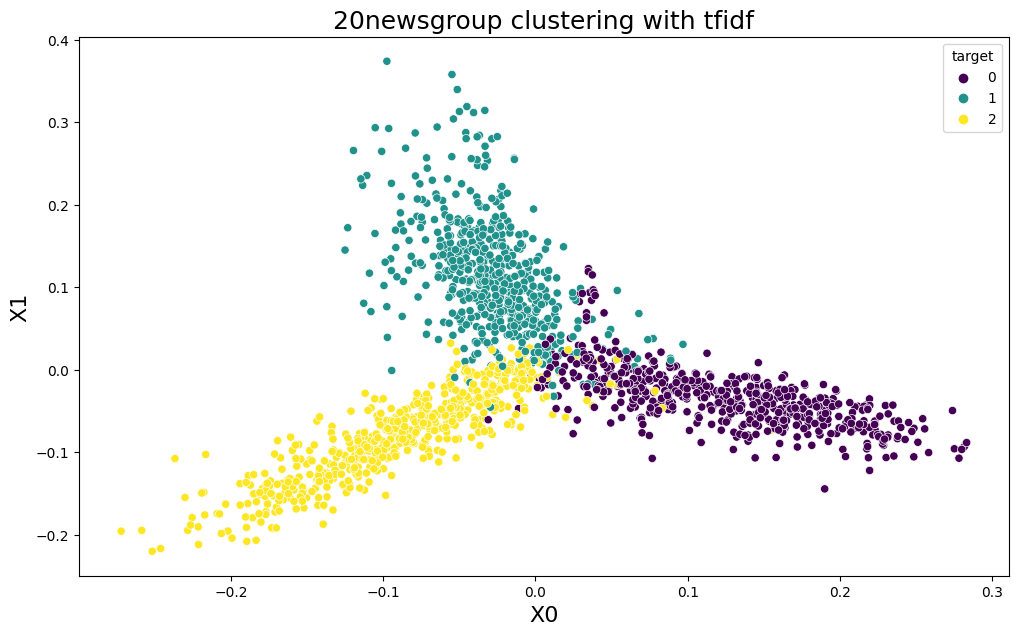

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Normalized Mutual Information (NMI): 0.061
Fowlkes-Mallows Index (FMI): 0.389
Silhouette Score: 0.113
Davies-Bouldin Index: 3.429
predict:


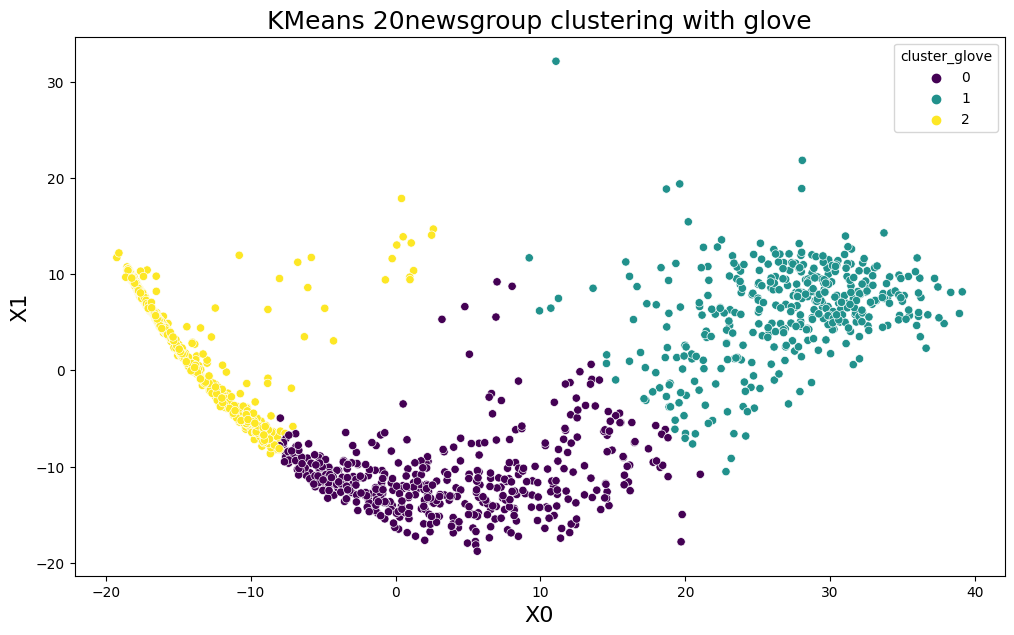

true


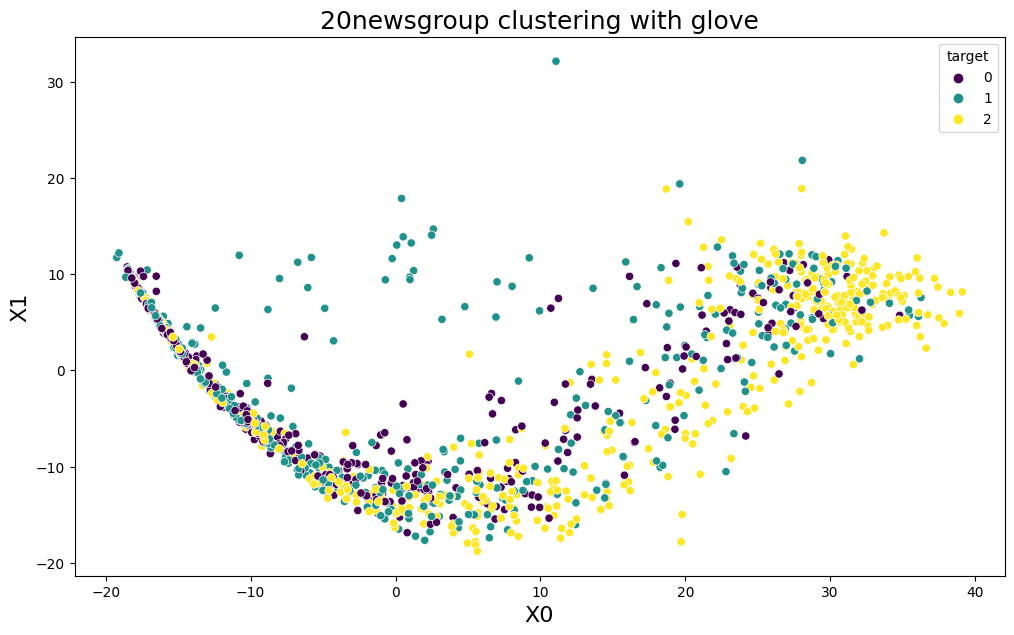

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Normalized Mutual Information (NMI): 0.018
Fowlkes-Mallows Index (FMI): 0.572
Silhouette Score: 0.877
Davies-Bouldin Index: 0.555
predict:


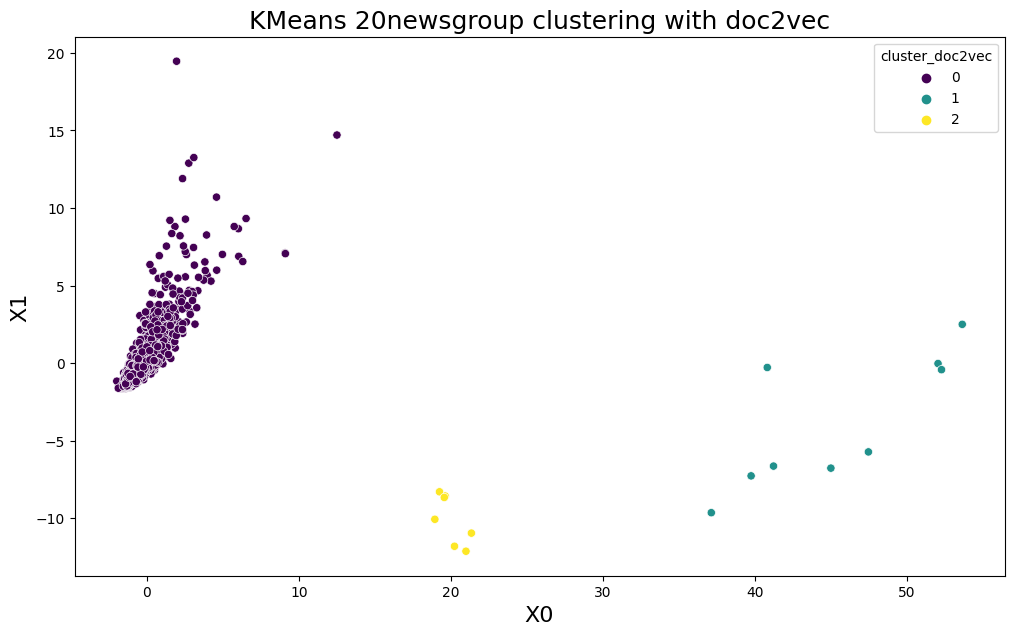

true


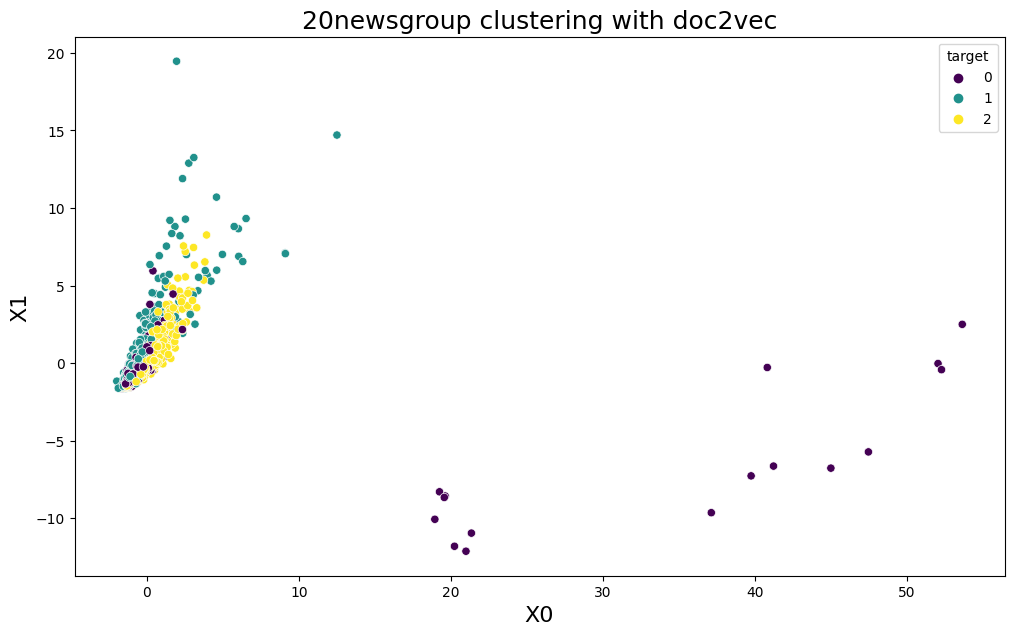

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Normalized Mutual Information (NMI): 0.854
Fowlkes-Mallows Index (FMI): 0.929
Silhouette Score: 0.090
Davies-Bouldin Index: 3.178
predict:


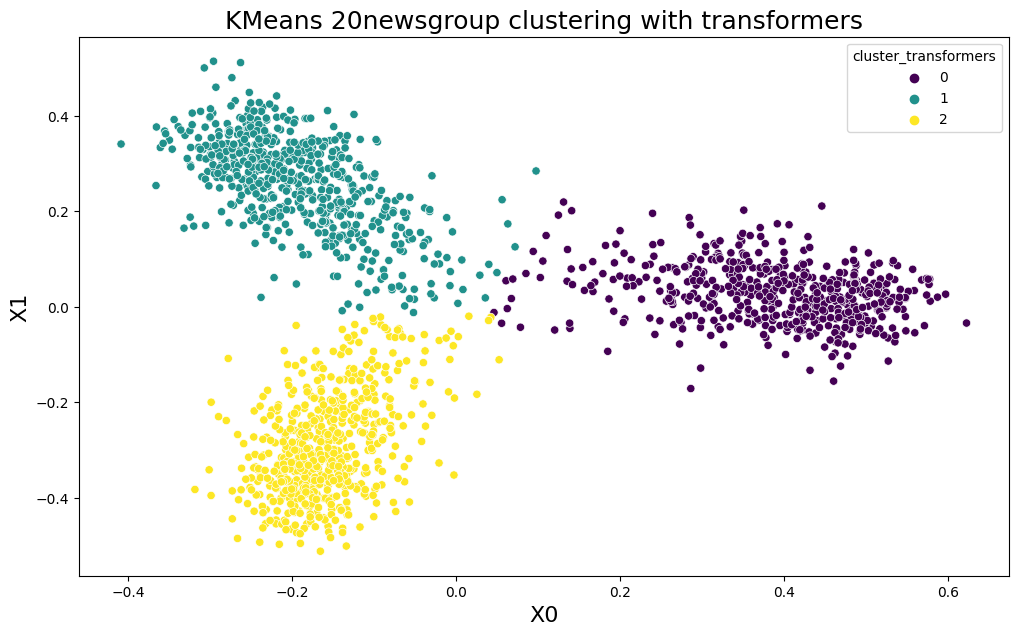

true


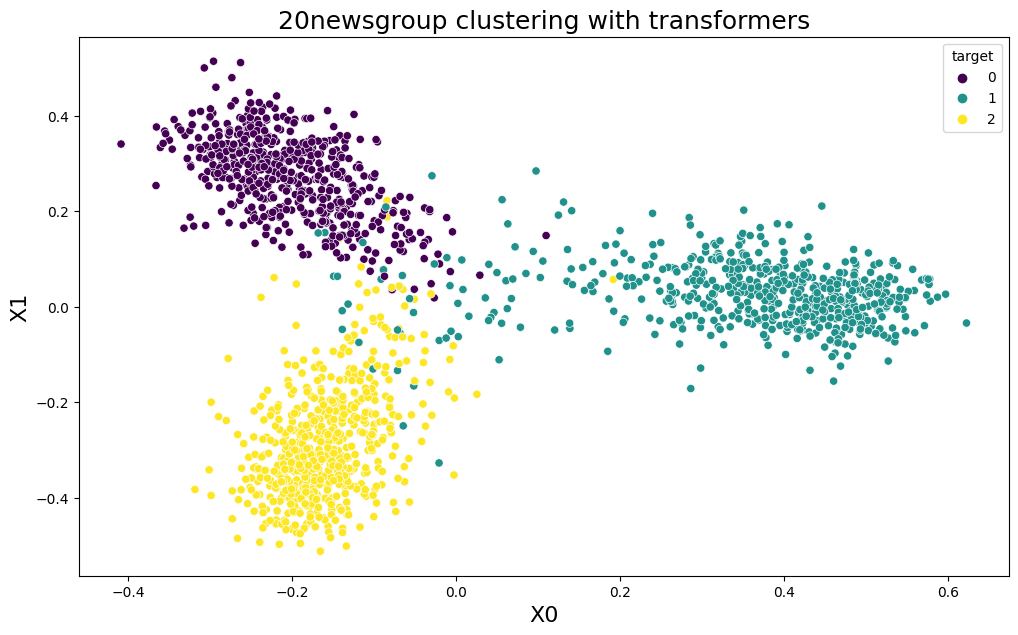

In [ ]:
for embedding_and_method in [(X, 'tfidf'), (X_glove, 'glove'), (X_doc2vec, 'doc2vec'), (X_transformers, 'transformers')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=3, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters

    kmeans_eval_cluster(embedding)

    dimension_reduction(embedding, method)
    print('predict:')
    plot_pca_kmeans(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)
    print('true')
    plot_pca_kmeans_true(f'x0_{method}', f'x1_{method}',method)


AgglomerativeClustering

Sample counts for each cluster using tfidf:
2    632
1    565
0    534
dtype: int64
Normalized Mutual Information (NMI): 0.667
Fowlkes-Mallows Index (FMI): 0.820
Silhouette Score: 0.010
Davies-Bouldin Index: 9.408


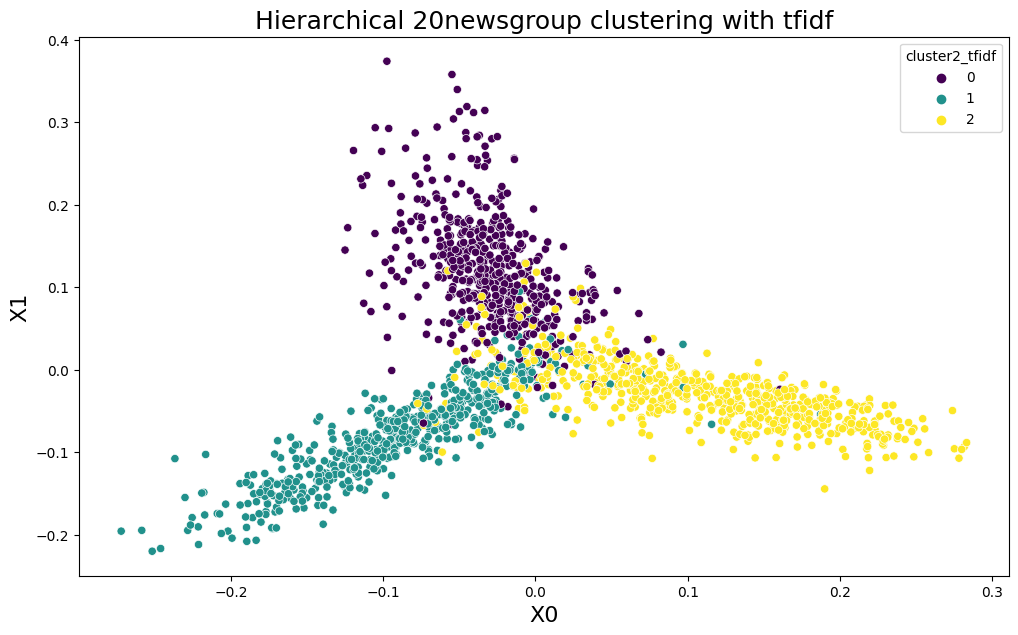

Sample counts for each cluster using glove:
0    984
1    421
2    326
dtype: int64
Normalized Mutual Information (NMI): 0.067
Fowlkes-Mallows Index (FMI): 0.411
Silhouette Score: 0.150
Davies-Bouldin Index: 3.744


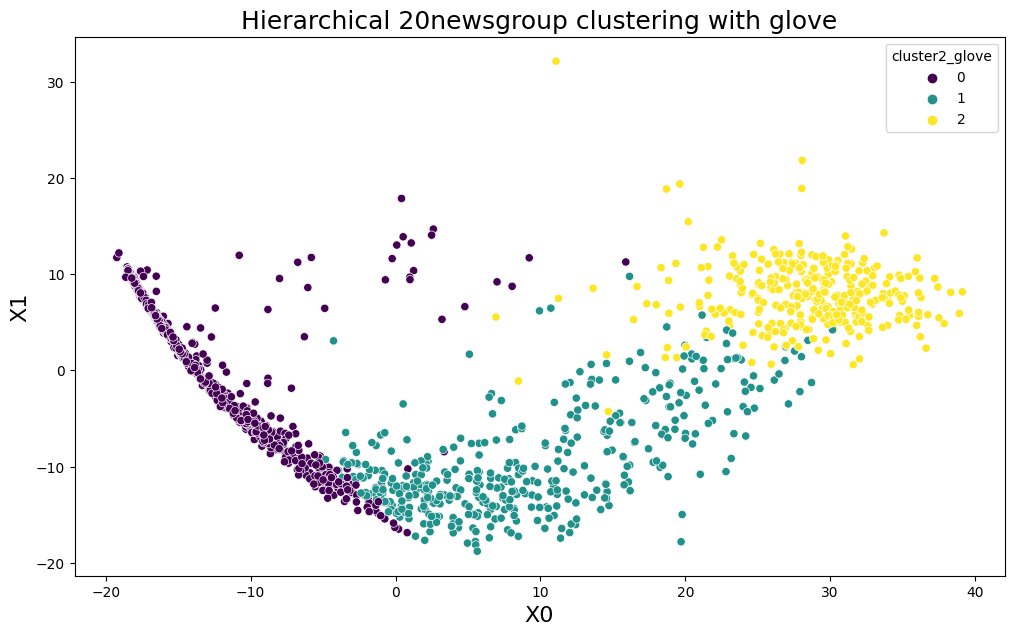

Sample counts for each cluster using doc2vec:
0    1715
1       9
2       7
dtype: int64
Normalized Mutual Information (NMI): 0.018
Fowlkes-Mallows Index (FMI): 0.572
Silhouette Score: 0.879
Davies-Bouldin Index: 0.562


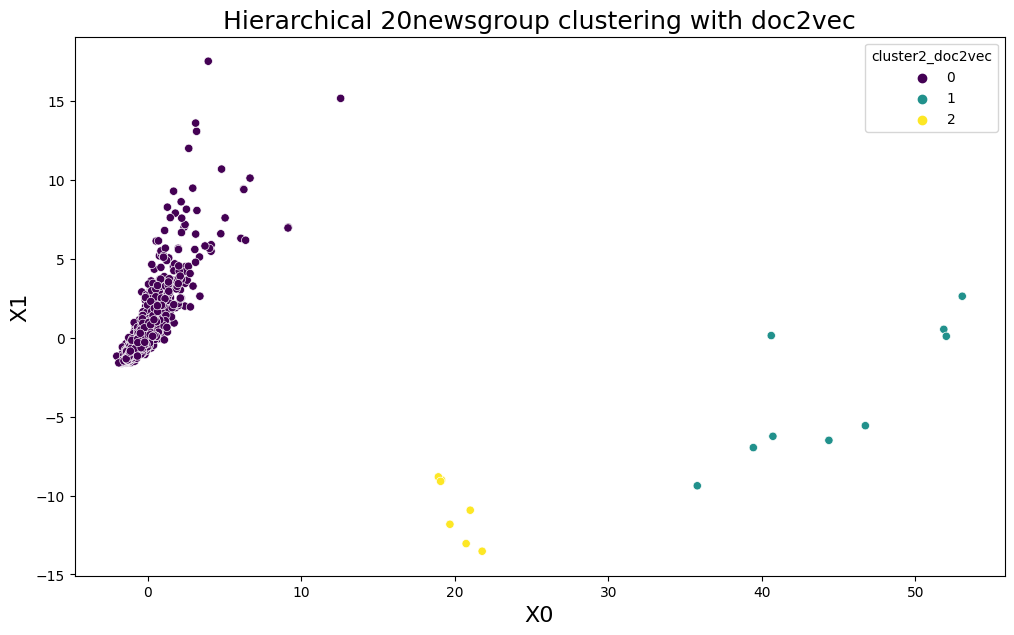

Sample counts for each cluster using transformers:
0    656
2    545
1    530
dtype: int64
Normalized Mutual Information (NMI): 0.826
Fowlkes-Mallows Index (FMI): 0.909
Silhouette Score: 0.087
Davies-Bouldin Index: 3.265


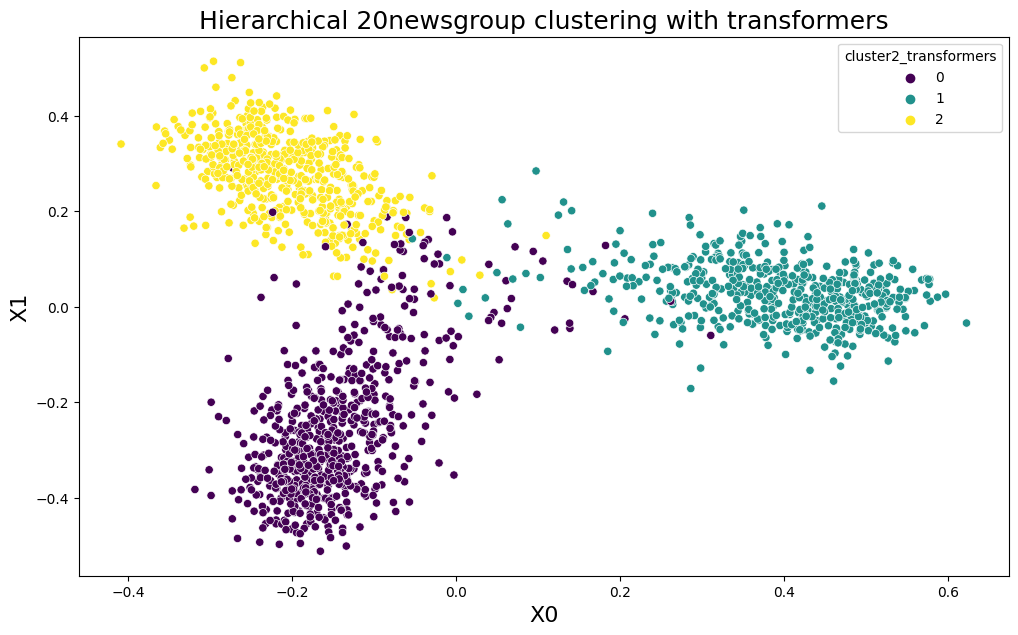

In [ ]:
from sklearn.cluster import AgglomerativeClustering


for embedding_and_method in [(X, 'tfidf'), (X_glove, 'glove'), (X_doc2vec, 'doc2vec'), (X_transformers, 'transformers')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')#, affinity='cosine')
    clusters = hierarchical.fit(embedding)

    # store cluster labels in a variable
    clusters = hierarchical.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster2_{method}'
    df[clusters_result_name] = clusters

    # Calculate and print the number of samples in each cluster
    print(f"Sample counts for each cluster using {method}:")
    print(pd.Series(clusters).value_counts())

    # Presumably eval_cluster is a function that evaluates the clusters
    hierarchical_eval_cluster(embedding)

    # Presumably dimension_reduction is a function that reduces dimensions
    dimension_reduction(embedding, method)

    # Presumably plot_pca is a function that plots the PCA of the clusters
    plot_pca_hierarchical(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)


tf-idf 降维比较

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.778
Normalized Mutual Information (NMI): 0.739
Fowlkes-Mallows Index (FMI): 0.853


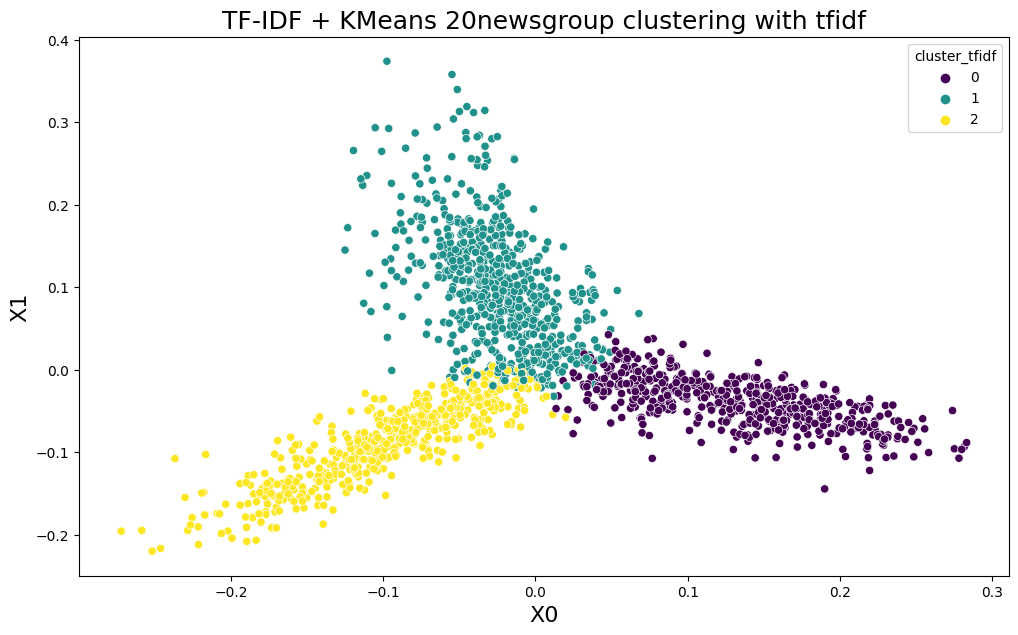

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.745
Normalized Mutual Information (NMI): 0.728
Fowlkes-Mallows Index (FMI): 0.831


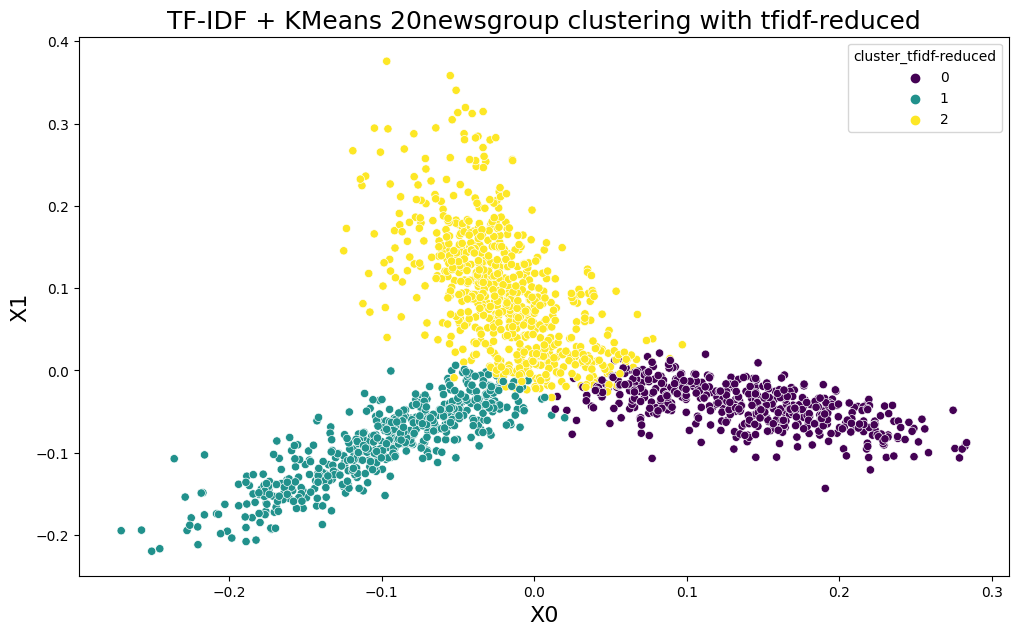

In [ ]:
for embedding_and_method in [(X, 'tfidf'), (X_reduced, 'tfidf-reduced')]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]

    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=3, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters

    kmeans_eval_cluster(embedding)

    dimension_reduction(embedding, method)

    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)